In [4]:
import gym
import numpy as np
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from gym import error, spaces, utils
from gym.utils import seeding

# Create a custom environment 
class WTAEnv(gym.Env):
    metadata = {'render.modes': ['console']}

    def __init__(self, n, m, lower_val, upper_val, prob, device):
        ''' 
        n - number of targets
        m - number of weapons
        lower_val/upper_val - lower/upper range to randomly generate target values from
        prob - m x n array where prob[i, j] = probability of weapon i killing target j
        ''' 
        super(WTAEnv, self).__init__()
        
        self.n = n
        self.m = m
        self.device = device
        
        self.target_values = np.random.uniform(lower_val, upper_val, self.n) 
        self.prob = prob
        # q = probability array of survival
        self.q = 1 - self.prob
        
        self.reset()

        # Current expected value of the assignment
        self.value = self.assignment_value()
        
        # The action space - a number 0 <= i < m * n, where
        # (weapon = i // n, target = i % n)
        # Assigns weapon to target (one target per weapon)
        self.action_space = spaces.MultiDiscrete([self.m * self.n])
        
    def decode_action(self, action):
        '''
        Given an action, return the weapon and target associated with
        that action.
        '''
        return action // self.n, action % self.n
        
    def get_onehot_assignments(self):
        '''
        Get a one-hot encoded representation of the assignments.
        This is used only because this representation is convenient and
        fast for computing the assignment value, since we can use
        vectorization and not use for loops. Not sure how much this
        actually helps though.
        '''
        onehot = np.zeros((self.m, self.n))
        onehot[np.arange(onehot.shape[0]), self.assignment] = 1
        return onehot
 
    def assignment_value(self):
        '''
        Compute the expected value of our assignment.
        E = Sum over targets i [P(target i killed) * Value(i)]
        where P(target i killed) = 1 - P(i survives)
        where P(i surves) = 1 - Product over weapons j [P(i survives j) = q[i, j]]
        '''
        pkill = 1 - np.prod(self.q ** self.assignment_onehot, axis=0)
        expected_value = np.dot(pkill, self.target_values)
        return expected_value
        
    def step(self, action):
        '''Perform action on the current state'''
        weapon, target = self.decode_action(action[0])
        if weapon < 0 or weapon >= self.m or target < 0 or target >= self.n:
            raise ValueError("Received invalid action={} which is not part of the action space".format(action))
        # Update assignments
        old_target = self.assignment[weapon]
        self.assignment[weapon] = target
        self.assignment_onehot[weapon, old_target] = 0
        self.assignment_onehot[weapon, target] = 1

        # Reward is change in assignment value
        new_value = self.assignment_value()
        reward = new_value - self.value
        self.value = new_value

        # There is no stopping condition other than the max number of iterations
        done = False

        return (self.get_state(), reward, done, {})

    def get_state(self):
        '''
        Our state is a size m + n array.
        state[:m] is self.assignments
        state[m:] is self.target_values
        '''
        state = np.concatenate([self.assignment, self.target_values])
        return torch.tensor(state, device=self.device)

    def reset(self):
        '''
        Important: the observation must be a numpy array
        :return: (np.array) 
        '''
        self.assignment = self.generate_initial_assignment()
        self.assignment_onehot = self.get_onehot_assignments()
        return self.get_state()
    
    def generate_initial_assignment(self):
        '''   
        Randomly assign weapons to targets
        ''' 
        assignment = np.random.randint(self.n, size=self.m)
        return assignment

    def render(self, mode='human', close=False):
        pass

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
steps_done = 0

def is_possible(state, weapon, target):
    '''
    We don't want to assign a weapon to the target if it is already assigned
    to the target, since this does not change the state at all.
    '''
    curr_target = state[weapon].item()
    return curr_target != target 

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        ## Exploit
        with torch.no_grad():
            policy_net.eval()
            state_batch = torch.unsqueeze(state, 1).transpose(0, 1).float()
            largest = torch.sort(policy_net(state_batch), descending=True, dim=1)[1]
            policy_net.train()
            
            # Try until we get a valid action
            for i in largest[0]:
                weapon = i / n
                target = i % n
                
                if is_possible(state, weapon.item(), target.item()):
                    return torch.tensor([i], device=device)
                
            # This should never happen
            raise ValueError('Invalid state: no possible action')
    else:
        ## Explore
        weapon = np.random.randint(m)
        curr_target = state[weapon].item()
        target = np.random.randint(n)
        while target == curr_target:
            target = np.random.randint(n)
        
        action = weapon * n + target
        return torch.tensor([action], device=device, dtype=torch.long)

In [8]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
        
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state
                                                if s is not None])
        
    state_batch = torch.stack(batch.state)
    action_batch = torch.stack(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values.double(), expected_state_action_values.unsqueeze(1).double())
    value_loss = loss.item()
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    return value_loss

In [9]:
'''Take in n by m matrix, convert it to 1D feature vector '''
class DQN(nn.Module):
    def __init__(self, n, m, embedding_size=8, units=64):
        super(DQN, self).__init__()
        # The assignment becomes embedded, so it has size m * embedding_size
        # when flattened
        # The n comes from the values attached
        self.assignment_size = m * embedding_size
        self.input_size = self.assignment_size + n
        self.output_size = m * n
        self.n = n
        self.m = m
    
        self.embedding_size = embedding_size
        # Embed the targets, since the actual numerical value of the
        # targets don't mean anything
        # Another idea: skip the middleman and replace the targets
        # with the target values
        self.embedding = nn.Embedding(n, self.embedding_size)
        self.lin1 = nn.Linear(self.input_size, units)
        self.drop1 = nn.Dropout(0.2)
        self.lin2 = nn.Linear(units, self.output_size)
        self.drop2 = nn.Dropout(0.2)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, state):
        assignment = state[:, :self.m].long()
        assignment = self.embedding(assignment)
        
        values = state[:, self.m:].float()
                
        # Flatten the assignment embedding
        assignment = assignment.view(-1, self.assignment_size).float() 
        
        # and concatenate the values
        x = torch.cat([assignment, values], dim=1)
        
        x = F.relu(self.drop1(self.lin1(x)))
        x = F.relu(self.lin2(x))
        return x

In [10]:
# with dueling networks
class DuelingDQN(nn.Module):

    def __init__(self, n, m, embedding_size=8, units=128):
        super(DuelingDQN, self).__init__()
        # The assignment becomes embedded, so it has size m * embedding_size
        # when flattened
        # The n comes from the values attached
        self.assignment_size = m * embedding_size
        self.input_size = self.assignment_size + n
        self.output_size = m * n
        self.n = n
        self.m = m
      
        self.units = units

        self.embedding_size = embedding_size
        # Embed the targets, since the actual numerical value of the
        # targets don't mean anything
        # Another idea: skip the middleman and replace the targets
        # with the target values
        self.embedding = nn.Embedding(n, self.embedding_size)
        self.lin1 = nn.Linear(self.input_size, units)
        self.drop1 = nn.Dropout(0.2)

        # Layer to measure the value of a state
        self.value_stream = nn.Sequential(
            nn.Linear(units, units),
            nn.ReLU(),
            nn.Linear(units, 1)
        )
        # Layer to measure the advantages of an action given a state
        self.advantage_stream = nn.Sequential(
            nn.Linear(units, units),
            nn.ReLU(),
            nn.Linear(units, self.output_size)
        )

    def forward(self, state):
        assignment = state[:, :self.m].long()
        assignment = self.embedding(assignment)


        values = state[:, self.m:].float()

        # Flatten the assignment embedding
        assignment = assignment.view(-1, self.assignment_size).float() 
        
        # and concatenate the values
        x = torch.cat([assignment, values], dim=1)
        x = F.relu(self.drop1(self.lin1(x)))
        values = self.value_stream(x)
        advantages = self.advantage_stream(x)
        qvals = values + (advantages - advantages.mean())
        
        return qvals

    def feature_size(self):
        return self.conv(autograd.Variable(torch.zeros(1, *self.input_dim))).view(1, -1).size(1)

In [17]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 100
MAX_ITERATIONS = 500

# n - number of targets
n = 10
# m - number of weapons
m = 10
assert n > 1

lower_val = 25
upper_val = 50
lower_prob = 0.6
upper_prob = 0.9
prob = np.random.uniform(lower_prob, upper_prob, (m, n))
env = WTAEnv(n, m, lower_val, upper_val, prob, device)

policy_net = DuelingDQN(n, m, n // 2, 64).to(device)
target_net = DuelingDQN(n, m, n // 2, 64).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

episode 0/100, iteration 499/500 loss: 2.4298387005291127
episode 1/100, iteration 499/500 loss: 5.7874904085865245
episode 2/100, iteration 499/500 loss: 4.2368169103404485
episode 3/100, iteration 499/500 loss: 3.6017581875957427
episode 4/100, iteration 499/500 loss: 3.1936257990636562
episode 5/100, iteration 499/500 loss: 2.7593114686864296
episode 6/100, iteration 499/500 loss: 4.1399495363718854
episode 7/100, iteration 499/500 loss: 5.1027685555881717
episode 8/100, iteration 499/500 loss: 4.7419757590803435
episode 9/100, iteration 499/500 loss: 4.8169216835962415
episode 10/100, iteration 499/500 loss: 7.0625874032344985
episode 11/100, iteration 499/500 loss: 6.8811031250323125
episode 12/100, iteration 499/500 loss: 6.7776724024662025
episode 13/100, iteration 499/500 loss: 7.5625402037358735
episode 14/100, iteration 499/500 loss: 7.6091263753583275
episode 15/100, iteration 499/500 loss: 8.6310593313154415
episode 16/100, iteration 499/500 loss: 8.1619751146526365
episode

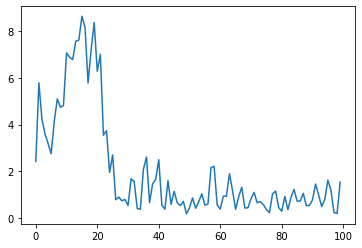

In [18]:
num_episodes = 100
# env.reset()
# init_state = env.get_state()
losses = []
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    state = env.get_state()
    for t in range(MAX_ITERATIONS):
        # Select and perform an action
        action = select_action(state)
        observation, reward, done, _ = env.step(action)
        reward = torch.tensor([reward], device=device)

        if not done:
            next_state = observation
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        loss = optimize_model()
        
        if done:
            break
        
        print(f'episode {i_episode}/{num_episodes}, iteration {t}/{MAX_ITERATIONS} loss: {loss}', end='\r')
    losses.append(loss)
    print()
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print()
print('Complete')
env.render()
env.close()

x = np.arange(len(losses))
plt.plot(x, losses)
plt.show()

In [19]:
policy_net.eval()

DuelingDQN(
  (embedding): Embedding(10, 5)
  (lin1): Linear(in_features=60, out_features=64, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (value_stream): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (advantage_stream): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=100, bias=True)
  )
)

In [20]:
def test_performance(runs, steps=10):
    avg_improvement = 0
    
    for i in range(runs):
        test_env = WTAEnv(n, m, lower_val, upper_val, prob, device)

        init_value = test_env.value
        improvement = 0
        for j in range(steps):
            state = test_env.get_state().unsqueeze(1).transpose(0, 1)
            best_action = policy_net(state).max(1)[1]

            _, change, _, _ = test_env.step(best_action)
            improvement += change
        
        avg_improvement += (improvement / init_value)
    
    avg_improvement /= runs
    
    return avg_improvement

In [22]:
# On average, how much does stepping according to the trained network improve the value of the assignment?
# Is a percent improvement
# any value >0 probably means some level of generalization
print(test_performance(1000, 10))

0.019803017476295502
